10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step
Classification Report:
              precision    recall  f1-score   support

    Unbiased       0.62      0.60      0.61       106
      Biased       0.69      0.73      0.71        98
     Opinion       0.71      0.68      0.70       107

    accuracy                           0.67       311
   macro avg       0.67      0.67      0.67       311
weighted avg       0.67      0.67      0.67       311



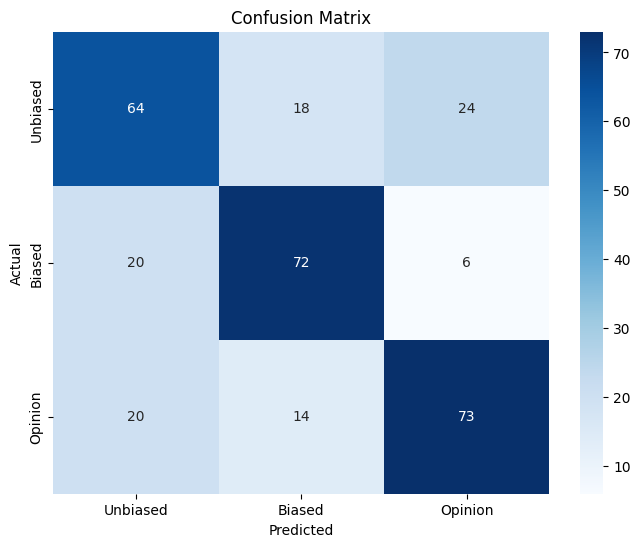

G-AUC Score (macro): 0.8327


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from tensorflow.keras.models import load_model

# Load validation data
X_val = np.load('/content/X_val_final_mc.npy')
y_val = np.load('/content/y_val_enc.npy')  # One-hot encoded

# Load your best model
model = load_model('/content/bias_detection_best_model67%.keras')

# Predict probabilities and classes
y_pred_probs = model.predict(X_val)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_val, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=["Unbiased", "Biased", "Opinion"]))

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Unbiased", "Biased", "Opinion"],
            yticklabels=["Unbiased", "Biased", "Opinion"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# G-AUC Score (macro average)
auc_score = roc_auc_score(y_val, y_pred_probs, multi_class='ovo', average='macro')
print(f"G-AUC Score (macro): {auc_score:.4f}")


In [ ]:
import numpy as np
import torch
from transformers import BertTokenizer, BertModel

# Load tokenizer and model once
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

# Class names (adjust if needed)
class_names = ['Unbiased', 'Biased', 'Opinion']

# Load your trained Keras model
from tensorflow.keras.models import load_model
model = load_model('/content/bias_detection_best_model67%.keras')

# Metadata feature columns (order must match training)
metadata_cols = [
    'topic_abortion', 'topic_coronavirus', 'topic_elections-2020',
    'topic_environment', 'topic_gender', 'topic_gun-control',
    'topic_immigration', 'topic_international-politics-and-world-news',
    'topic_middle-class', 'topic_sport', 'topic_student-debt',
    'topic_trump-presidency', 'topic_vaccines', 'topic_white-nationalism',
    'type_center', 'type_left', 'type_right'
]

# Example: all-zero metadata except one topic and one type
def create_metadata_vector(selected_topic, selected_type):
    metadata_vector = [0] * len(metadata_cols)
    if selected_topic in metadata_cols:
        metadata_vector[metadata_cols.index(selected_topic)] = 1
    if selected_type in metadata_cols:
        metadata_vector[metadata_cols.index(selected_type)] = 1
    return np.array(metadata_vector)

# Generate BERT embedding
def get_bert_embeddings(text):
    try:
        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
        with torch.no_grad():
            outputs = bert_model(**inputs)
        return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()
    except Exception as e:
        print(f"Error processing: {text} → {e}")
        return np.zeros(768)

# Full prediction function
def predict_class(text, topic='topic_immigration', type_='type_left'):
    sentence_vec = get_bert_embeddings(text)  # shape (768,)
    meta_vec = create_metadata_vector(topic, type_)  # shape (17,)
    final_input = np.concatenate([sentence_vec, meta_vec]).reshape(1, -1)  # shape (1, 785)
    probs = model.predict(final_input)[0]
    pred_class = np.argmax(probs)
    print(f"\nInput: {text}")
    print(f"Prediction Score: {probs[pred_class]:.4f} → {class_names[pred_class]}")
    return class_names[pred_class]


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
predict_class("The government should cut taxes for working-class families.", topic='topic_middle-class', type_='type_left')
predict_class("Aliens might have visited Earth in ancient times.", topic='topic_environment', type_='type_center')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step

Input: The government should cut taxes for working-class families.
Prediction Score: 0.6163 → Biased
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step

Input: Aliens might have visited Earth in ancient times.
Prediction Score: 0.7385 → Opinion


'Opinion'

In [ ]:
predict_class(
    "The central bank announced a 0.5% interest rate increase to control inflation.\n"
    "This change is expected to impact mortgage rates and credit card loans.\n"
    "Analysts believe the move is a response to rising consumer prices.\n"
    "The policy will be reviewed again next quarter.",
    topic='topic_middle-class', type_='type_center'
)

predict_class(
    "NASA successfully launched a new satellite to monitor global climate changes.\n"
    "The satellite will gather data on sea levels and atmospheric temperature.\n"
    "This mission is part of a broader initiative for environmental research.\n"
    "Scientists anticipate first results within three months.",
    topic='topic_environment', type_='type_center'
)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step

Input: The central bank announced a 0.5% interest rate increase to control inflation.
This change is expected to impact mortgage rates and credit card loans.
Analysts believe the move is a response to rising consumer prices.
The policy will be reviewed again next quarter.
Prediction Score: 0.9384 → Opinion
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step

Input: NASA successfully launched a new satellite to monitor global climate changes.
The satellite will gather data on sea levels and atmospheric temperature.
This mission is part of a broader initiative for environmental research.
Scientists anticipate first results within three months.
Prediction Score: 0.9500 → Opinion


'Opinion'

In [ ]:
predict_class(
    "This policy is just another way for the elite to control the poor.\n"
    "It clearly benefits corporations while hurting ordinary citizens.\n"
    "Every time, the rich get richer while the working class suffers.\n"
    "This is not reform; it's exploitation.",
    topic='topic_middle-class', type_='type_left'
)

predict_class(
    "Once again, the media is covering up the real truth about vaccines.\n"
    "They push an agenda without letting people question the science.\n"
    "Anyone who asks questions is instantly labeled as dangerous.\n"
    "This isn't health, it's censorship.",
    topic='topic_vaccines', type_='type_right'
)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step

Input: This policy is just another way for the elite to control the poor.
It clearly benefits corporations while hurting ordinary citizens.
Every time, the rich get richer while the working class suffers.
This is not reform; it's exploitation.
Prediction Score: 0.9670 → Biased
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step

Input: Once again, the media is covering up the real truth about vaccines.
They push an agenda without letting people question the science.
Anyone who asks questions is instantly labeled as dangerous.
This isn't health, it's censorship.
Prediction Score: 0.9327 → Biased


'Biased'

In [ ]:
predict_class(
    " social media is destroying face-to-face communication.\n"
    "We spend more time curating profiles than having real conversations.\n"
    "I think society is becoming lonelier despite being more connected.\n"
    "Digital connection can never replace human interaction.",
    topic='topic_coronavirus', type_='type_center'
)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step

Input:  social media is destroying face-to-face communication.
We spend more time curating profiles than having real conversations.
I think society is becoming lonelier despite being more connected.
Digital connection can never replace human interaction.
Prediction Score: 0.4712 → Opinion


'Opinion'

In [ ]:
import re

def clean_text(text):
    text = text.lower()  # Lowercase
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    return text